# SET UP

## IMPORTS, DEFAULT PLOTTING THEMES, AND USEFUL FUNCTIONS

In [1]:
import os, sys, git, time, ntpath, tracemalloc, sqlite3, pandas as pd, numpy as np
from pandas.api.types import CategoricalDtype
from scripts.log_processing.plotting import *
# from scripts.log_processing import data_loader as loader

# DO NOT IMPORT IN REAL SCRIPT:
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, Markdown

from scripts.utils.MazeParser import parse_maze


%matplotlib inline 
#widget


# DEFAULT FOLDERS AND FILES:

git_root = './'
folder_layers = git_root + 'experiments/pc_layers/'
folder_mazes = git_root + 'experiments/mazes/'
folder_log = git_root + 'experiments/pc_generation_experiments/logs/'
folder_configs = folder_log + 'config_files/'

layer_metrics_file = os.path.join(git_root, folder_layers + 'layer_metrics.csv')



## USEFUL FUNCTIONS:

def reset_gg_defaults():
    theme_default = theme_gray() + theme (
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
    )


    theme_set(theme_default)

reset_gg_defaults()



# PLOT PAIRWISE POSTHOC TEST

def plot_pairwise_posthoc_test(p_values,p_limit):
    # melts the dataframe with pvalues and plots heatmap (columns and indexes should be the groups as in the result of scikit posthoc dunn test)
    melted = p_values.melt(ignore_index = False).reset_index().set_axis(['group1','group2','p value'], axis=1)
    melted.group1 = melted.group1.astype('category')
    melted.group2 = melted.group2.astype('category')
    # display(melted)
    p0 = ggplot(melted, aes('group1', 'group2', fill='p value'))
    p0 += geom_tile()
    p0 += scale_fill_gradientn(colors = ['green','yellowgreen','lightcoral','red'] , values = [0,p_limit,p_limit + 1e-7,1])
    return p0



# GET DATA

def lastEpisode(configs, sample_rate):
    num_episodes = configs['numEpisodes'].max() / configs['numStartingPositions'].max() # all are supposed to have the same number of episodes
    last_episode = -sample_rate % num_episodes
    return last_episode

def getEpisodeDataAndRuntimeSummaries(db, configs, fields_to_add, episode, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET SUMMARIZED RUNTIME DATA
    metric = 'error_rate'
    summaries = None if skip_summary else augment_data(load_summary_medians(db, indices, metric), configs, fields_to_add)

    # GET EPISODE DATA:
    runtimes_episode = None if skip_runtimes else augment_data(load_episode_metrics(db, indices, episode), configs, fields_to_add)
            
    return summaries, runtimes_episode

def getLearningTimes(db, configs, fields_to_add):
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    learning_times = load_learning_times(db, indices)
    
    return augment_data(learning_times, configs, fields_to_add)

def augment_data(data, configs, fields):
    return pd.merge(data, configs[ ['c_id'] + fields ], left_on='config', right_on='c_id', how='left')



# TESTING & DEVELOPMENT

## PLOT MAZES

File exists!


x       y    d
0      -1.1025 -1.5025 -0.1
1      -1.0975 -1.5025 -0.1
2      -1.0925 -1.5025 -0.1
3      -1.0875 -1.5025 -0.1
4      -1.0825 -1.5025 -0.1
...        ...     ...  ...
265036  1.0775  1.4975 -0.1
265037  1.0825  1.4975 -0.1
265038  1.0875  1.4975 -0.1
265039  1.0925  1.4975 -0.1
265040  1.0975  1.4975 -0.1

[265041 rows x 3 columns]

'sample_maze2'

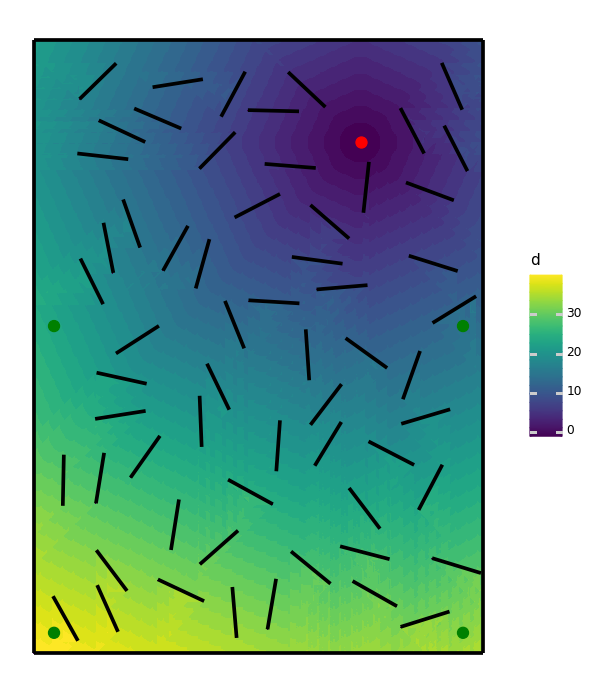

<ggplot: (131721825043)>

In [9]:
folder_maze_figures = 'figures/'
make_folder(folder_maze_figures)
pc_files = [
    #'uniform/u20_10',
    #'uniform/u40_10',
    #'uniform/u20_15',
    #'uniform/u40_15',
    #'multi_layer/ml_4_16_52',
    #'multi_layer/ml_4_16_52',
    # 'uniform/u40_05',
    # 'locally_uniform/lu0_40_16',
    # 'locally_uniform/lu0_40_16',
    # 'locally_uniform/lu1_40_16',
    # 'non_uniform/non_uniform_0',
    # 'non_uniform/non_uniform_1',
    # 'non_uniform/non_uniform_8',
    'NONE' #'../../experiments/pc_generation_experiments/logs/test/configs/c0/r0-pc_layer0'
]
maze_files = [
    #'obstacles/M100',
    #'obstacles/M200',
    #'obstacles/M300',
    #'obstacles/M400',
    #'obstacles/M500',
    #'obstacles/M600',
    # 'M1',
    # 'M0',
    # 'M1',
    # 'M1',
    # 'M0',
    # 'M1',
    # 'M8',
    'obstacles/M600',
]

save_names = [
    #'M100_u20_10',
    #'M200_u40_15',
    #'M300_u20_15',
    #'M400_u40_15',
    #'M500_ml',
    #'M600_ml',
    # 'M1_u',
    # 'M0_lu0',
    # 'M1_lu0',
    # 'M1_lu1',
    # 'M0_nu',
    # 'M1_nu',
    # 'M2_nu'
    'sample_maze2'
]


thetas = np.arange(100)/100*2*np.pi
unit_circle = pd.DataFrame({'x':np.cos(thetas),'y':np.sin(thetas)})
def draw_circle(x,y,r, **kwargs):
    circle = unit_circle*r + [x,y]
    return geom_path(aes(x='x',y='y'), data=circle, **kwargs)


for (p_file, m_file, s_name) in zip(pc_files, maze_files, save_names):

    p = ggplot()
    
    
    
    # # If maze file is not none and it has distance file, plot distance heatmap first
    # d_file = folder_mazes + m_file + '_subgoal_distances.bin'
    # if m_file != 'NONE' and os.path.exists(d_file):
    #     print('File exists!')
    #     with open(d_file,'rb') as f:
    #         [min_x, num_x, min_y, num_y, precision] = np.fromfile(f, np.float32, 5) # format is: 
    #         distances = np.fromfile(f, np.float32, int(num_x*num_y))
    #         [ys, xs] = np.mgrid[0:num_y,0:num_x].reshape(2,-1)
    #         xs = xs*precision + min_x
    #         ys = ys*precision + min_y
    #         distance_df = pd.DataFrame({'x':xs,'y':ys,'d':distances})
    #         display(distance_df)
    #         p += geom_tile(aes(x='x',y='y',fill='d'), data=distance_df)
    # else:
    #     print(f'distances to obstacle corners does not exist! {d_file}')
        
    # If maze file is not none and it has distance file, plot distance heatmap first
    d_file = folder_mazes + m_file + '_optimal_paths.bin'
    if m_file != 'NONE' and os.path.exists(d_file):
        print('File exists!')
        with open(d_file,'rb') as f:
            [min_x, num_x, min_y, num_y, precision] = np.fromfile(f, np.float32, 5)
            distances = np.fromfile(f, np.float32, int(num_x*num_y))
            distances[ distances == 10000 ] = -0.1
            prev_ids = np.fromfile(f, np.float32, int(num_x*num_y))
            [ys, xs] = np.mgrid[0:num_y,0:num_x].reshape(2,-1)
            xs = xs*precision + min_x
            ys = ys*precision + min_y
            distance_df = pd.DataFrame({'x':xs,'y':ys,'d':distances})
            display(distance_df)
            p += geom_tile(aes(x='x',y='y',fill='d'), data=distance_df)
    else:
        print(f'goal distances do not exist! {d_file}')
    
    
    # IF PCS is not none plot pcs:
    if p_file != 'NONE':
        pcs = pd.read_csv(folder_layers + p_file + '.csv')
        for id, pc in pcs.iterrows():
            p += draw_circle(pc['x'], pc['y'], pc['r'], color='gray')
    
    if m_file != 'NONE':
        walls, feeders, start_positions = parse_maze(folder_mazes + m_file + '.xml')
        p += geom_segment(aes(x='x1', y='y1', xend='x2', yend='y2'), data=walls, color='k', size=1.5)
        p += geom_point(aes(x='x', y='y'), data=feeders, color='r', size=4)
        p += geom_point(aes(x='x', y='y'), data=start_positions, color='g', size=4)
        
    # ADD THEMES TO PLOT
    p += coord_fixed(ratio = 1)
    p += theme_void()

    display(s_name)
    display(p)
    
    if s_name != 'NONE':
        ggsave(p, folder_maze_figures + s_name + '.png', dpi=300, verbose = False)

# PLOT VISIBILITY

## Visibility graph

num lines:  185 polys 122 Verif (2a-4)/3 == p 122.0 122


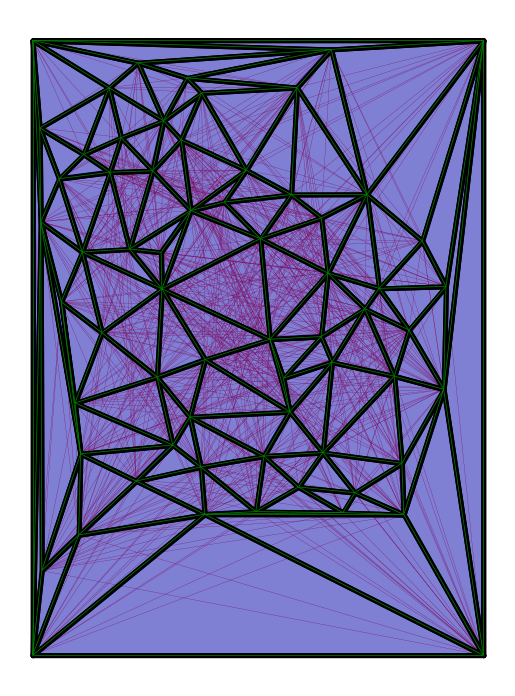

<ggplot: (160326625284)>

In [271]:
import importlib
import scripts.pc_and_maze_creation.tools.map_visibility.map_visibility as visibility_mapper
importlib.reload(visibility_mapper)
import scripts.pc_and_maze_creation.tools.map_visibility.map_visibility as visibility_mapper


folder_maze_figures = 'figures/'
make_folder(folder_maze_figures)

visibility_files = [
    #'obstacles/M100',
    'scripts/pc_and_maze_creation/tools/samples/M304_visibility_map.bin'
]

save_names = [
    #'M100_u20_10',
    # 'scripts/pc_and_maze_creation/tools/samples/M304_visibility_map.bin'
    None
]


for (v_file, s_name) in zip( visibility_files, save_names):

    p = ggplot()
    vmap = visibility_mapper.load_visibility_map(v_file)
    p = vmap.plot(p)
    polygons, lines_df = vmap.generate_polygons2()
    
    color = "#00FF00" if lines_df is None else "#000000"
    for poly in polygons:
        p += geom_polygon(aes(x='x',y='y'),data = poly, fill='#0000AA', alpha=0.5, color=color,size=2)
    
    
    if lines_df is not None:
        p += geom_segment(aes(x='x1', y='y1', xend='x2', yend='y2'), data=lines_df, color='g', size=0.3)
    
    if walls
    
    
    
    display(p)
            

## FINDING VISIBILITY POLYGONS:

In [93]:
import importlib
import scripts.pc_and_maze_creation.tools.map_visibility.map_visibility2 as visibility_mapper
importlib.reload(visibility_mapper)
import scripts.pc_and_maze_creation.tools.map_visibility.map_visibility2 as visibility_mapper

maze_folder = 'scripts/pc_and_maze_creation/tools/samples/'
maze_file   = 'M304.xml'



print('Mapping visibility in ', maze_file)
full_path = os.path.join(maze_folder, maze_file)
walls, feeders, start_positions = parse_maze(full_path)

# FIND POLYGONS
min_x, num_x, min_y, num_y, all_polygons = visibility_mapper.find_all_visibility_polygons(walls, 0.01)

# SAVE POLYGONS
# save_name = full_path.replace('.xml', '_visibility_map.bin')
# print('Saving ', save_name)
# save(save_name, min_x, num_x, min_y, num_y, all_polygons)




# PLOT MISSING POLYGONS TO CHECK FOR ERRORS
plot = visibility_mapper.plot_missing_polygons(walls, min_x, num_x, min_y, num_y, all_polygons, precision, ggplot())


Mapping visibility in  M304.xml


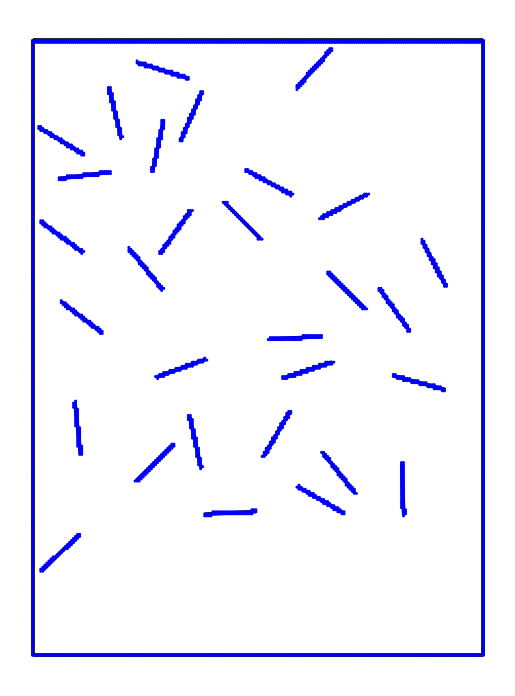

<ggplot: (138856866422)>

In [96]:
import importlib
import scripts.pc_and_maze_creation.tools.map_visibility.map_visibility2 as visibility_mapper
importlib.reload(visibility_mapper)
import scripts.pc_and_maze_creation.tools.map_visibility.map_visibility2 as visibility_mapper

precision = 0.01
# missing = [(min_x + precision * (i+0.5), min_y + precision * (j+0.5)) for i in range(num_x) for j in range(num_y) if all_polygons[i][j] is None]
# plot = visibility_mapper.plot_missing_polygons(walls, min_x, num_x, min_y, num_y, all_polygons, precision, ggplot())
display(plot)

# missing = [ (i,j) for i in range(num_x) for j in range(num_y) if all_polygons[i][j] is not None and not isinstance(all_polygons[i][j], Polygon)]
# missing_xy = [ (min_x + (ij[0]+0.5)*precision, min_y + (ij[1]+0.5)*precision) for ij in missing ]
# miss_id = 0
# ij = missing[miss_id]

# draw_polygons = all_polygons[ij[0]][ij[1]]

# p = ggplot()
# # if draw_polygon is not None:
#     #    
# p += geom_segment(aes(x='x1', y='y1', xend='x2', yend='y2'), data=walls, color='k', size=1.5)



# for poly in draw_polygons:
#     p += geom_polygon(aes(x='x',y='y'),data = poly_to_df(poly), fill='#0000AA', alpha=0.5, color='g',size=0.2)

# p += geom_point(aes(x='x', y='y'), data=pd.DataFrame({'x':[x for (x,y) in missing_xy], 'y':[y for (x,y) in missing_xy]}), color='b', size=1)
# p += geom_point(aes(x='x', y='y'), data=pd.DataFrame(columns = ['x','y'], data = [missing_xy[miss_id]]), color='r', size=0.1)  
 
    
# # ADD THEMES TO PLOT
# p += coord_fixed(ratio = 1)
# p += theme_void()
# display(p)

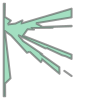

True

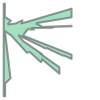

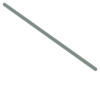

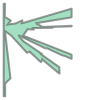

In [92]:
display(draw_polygons)
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
display(isinstance(draw_polygons, MultiPolygon))
for p in draw_polygons:
    display(p)

eps = 0.005
for p in draw_polygons:
    if p.contains(Point([cx,cy])):
        display(p.buffer(-eps).buffer(eps))  



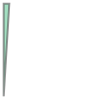

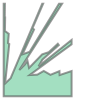

# Experiment 1 - pc generation threshold

In [4]:
from scripts.pc_and_maze_creation.data_generators import pc_layer_metrics as pc_metrics

experiment_name = 'experiment1-pcGenerationThreshold'
folder_experiment = folder_log + experiment_name + '/'
folder_results = folder_experiment + 'configs/'
file_configs = folder_configs + experiment_name + '.csv'


rat_configs = pd.read_csv(file_configs, sep='\t')
display(rat_configs)




def getLayerData(row):
    config = row['config'] 
    run_id = row['run_id']
    display(f'executing {config} {run_id}')
    radius = row['pc_generation_radii']
    threshold = row['pc_generation_threshold']
    pc_file = folder_results + config + f'/pcs_r{int(float(radius)*100)}_T{int(float(threshold)*1000)}_id{run_id}.csv'
    
    pcs = pd.read_csv(pc_file)
    num_pcs = pc_metrics.number_of_cells(pcs)
    redundancy = pc_metrics.coverage(pcs) # use default maze coordinates
    
    return pd.Series([radius,threshold,run_id, num_pcs, redundancy], index=['radius','threshold','rat','num_pcs', 'redundancy'])

metrics = rat_configs.apply(getLayerData, axis=1, result_type = 'expand')
metrics.to_csv(folder_experiment + 'resulting_pc_layer_metrics.csv', index=False)
display(metrics)




config                           experiment group  \
0        c0  experiments/setups/experiment_1.xml    g1   
1        c0  experiments/setups/experiment_1.xml    g1   
2        c0  experiments/setups/experiment_1.xml    g1   
3        c0  experiments/setups/experiment_1.xml    g1   
4        c0  experiments/setups/experiment_1.xml    g1   
...     ...                                  ...   ...   
2155   c107  experiments/setups/experiment_1.xml    g1   
2156   c107  experiments/setups/experiment_1.xml    g1   
2157   c107  experiments/setups/experiment_1.xml    g1   
2158   c107  experiments/setups/experiment_1.xml    g1   
2159   c107  experiments/setups/experiment_1.xml    g1   

                      mazeFile  numStartingPositions  numEpisodes  \
0     experiments/mazes/M0.xml                     7           70   
1     experiments/mazes/M0.xml                     7           70   
2     experiments/mazes/M0.xml                     7           70   
3     experiments/mazes/M0.xml                     7           70   
4     experiments/mazes/M0.xml                     7           70   
...                        ...                   ...          ...   
2155  experiments/mazes/M0.xml                     7           70   
2156  experiments/mazes/M0.xml                     7           70   
2157  experiments/mazes/M0.xml                     7           70   
2158  experiments/mazes/M0.xml                     7           70   
2159  experiments/mazes/M0.xml                     7           70   

                             pc_files  independent_pcs pc_modulation_method  \
0     experiments/pc_layers/empty.csv            False                 none   
1     experiments/pc_layers/empty.csv            False                 none   
2     experiments/pc_layers/empty.csv            False                 none   
3     experiments/pc_layers/empty.csv            False                 none   
4     experiments/pc_layers/empty.csv            False                 none   
...                               ...              ...                  ...   
2155  experiments/pc_layers/empty.csv            False                 none   
2156  experiments/pc_layers/empty.csv            False                 none   
2157  experiments/pc_layers/empty.csv            False                 none   
2158  experiments/pc_layers/empty.csv            False                 none   
2159  experiments/pc_layers/empty.csv            False                 none   

     pc_generation_method  pc_generation_radii  pc_generation_threshold  \
0                   layer                 0.08                    0.001   
1                   layer                 0.08                    0.001   
2                   layer                 0.08                    0.001   
3                   layer                 0.08                    0.001   
4                   layer                 0.08                    0.001   
...                   ...                  ...                      ...   
2155                layer                 0.56                    0.900   
2156                layer                 0.56                    0.900   
2157                layer                 0.56                    0.900   
2158                layer                 0.56                    0.900   
2159                layer                 0.56                    0.900   

      pc_generation_active_layers_only  save_pcs  traces  run_id  
0                                False      True       0       0  
1                                False      True       0       1  
2                                False      True       0       2  
3                                False      True       0       3  
4                                False      True       0       4  
...                                ...       ...     ...     ...  
2155                             False      True       0      15  
2156                             False      True       0      16  
2157                      

radius  threshold   rat  num_pcs  redundancy
0       0.08      0.001   0.0    512.0    1.508308
1       0.08      0.001   1.0    517.0    1.525577
2       0.08      0.001   2.0    517.0    1.522755
3       0.08      0.001   3.0    518.0    1.527668
4       0.08      0.001   4.0    511.0    1.515553
...      ...        ...   ...      ...         ...
2155    0.56      0.900  15.0    880.0  107.765546
2156    0.56      0.900  16.0    891.0  108.266668
2157    0.56      0.900  17.0    875.0  106.848222
2158    0.56      0.900  18.0    887.0  107.758886
2159    0.56      0.900  19.0    874.0  106.753310

[2160 rows x 5 columns]

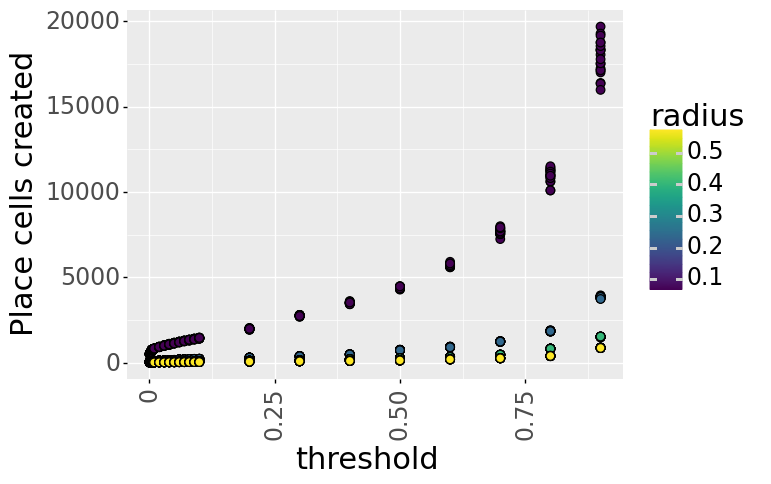

<ggplot: (167432217570)>

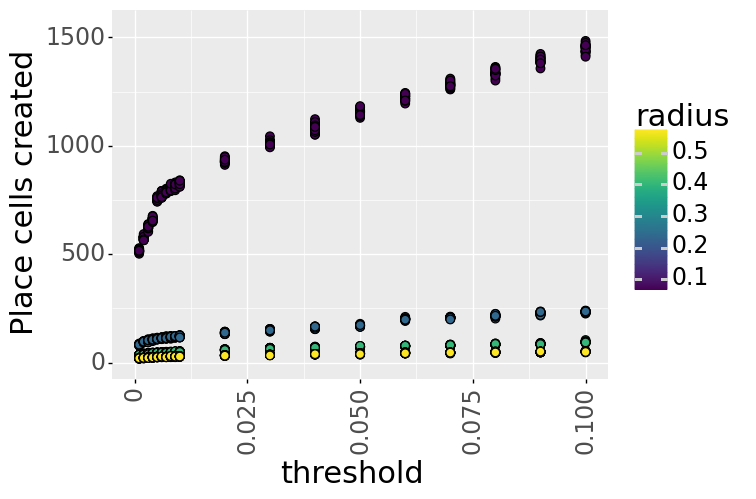

<ggplot: (167432217570)>

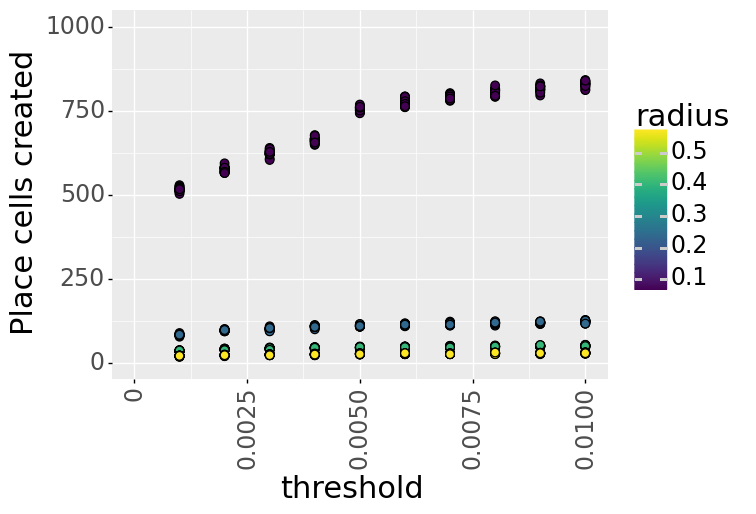

<ggplot: (167432217570)>

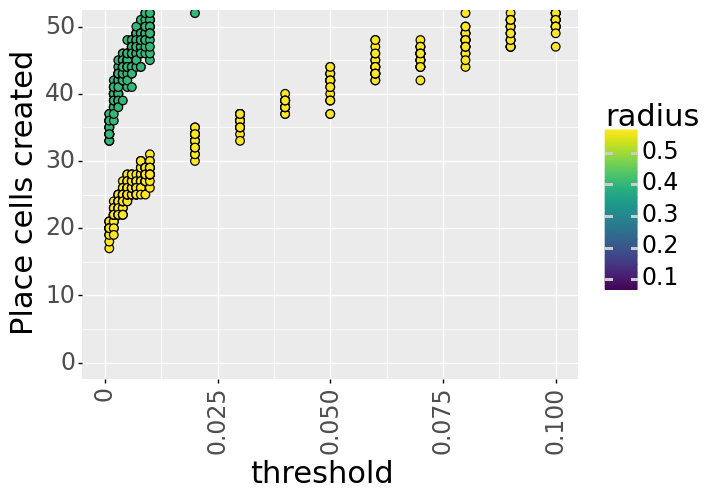

<ggplot: (167432217570)>

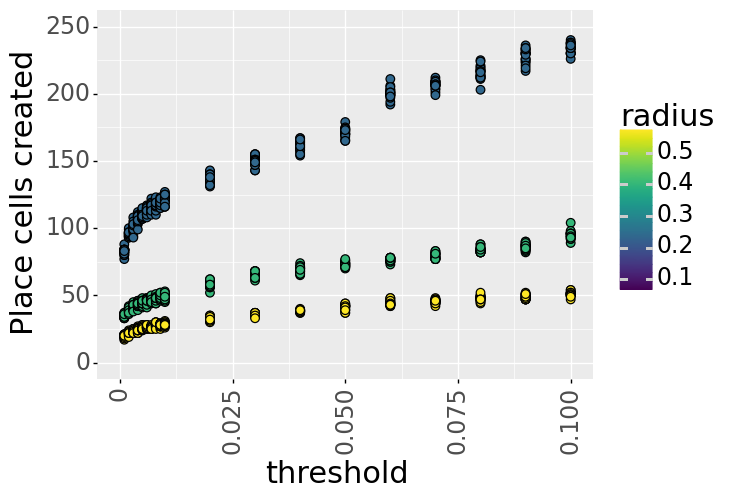

<ggplot: (167432217570)>

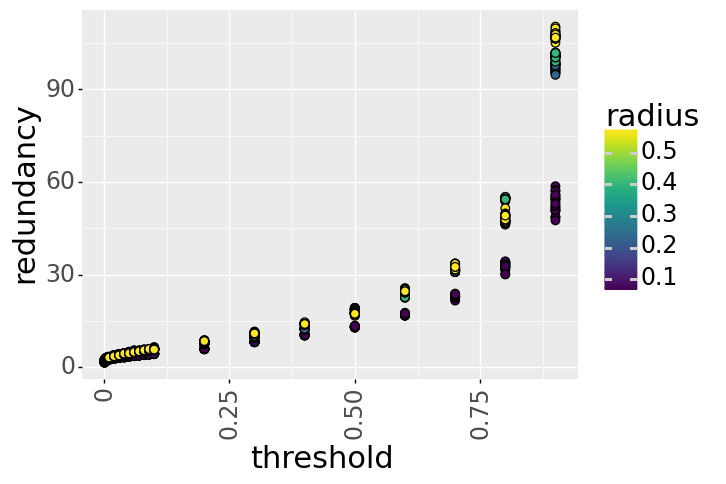

<ggplot: (167427531933)>

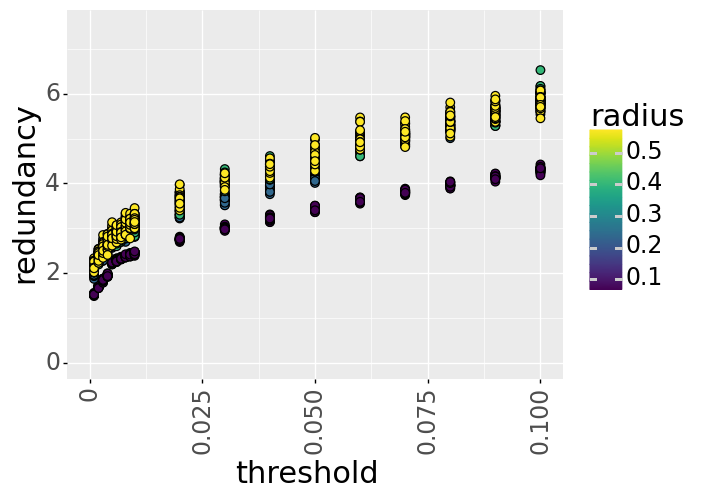

<ggplot: (167427531933)>

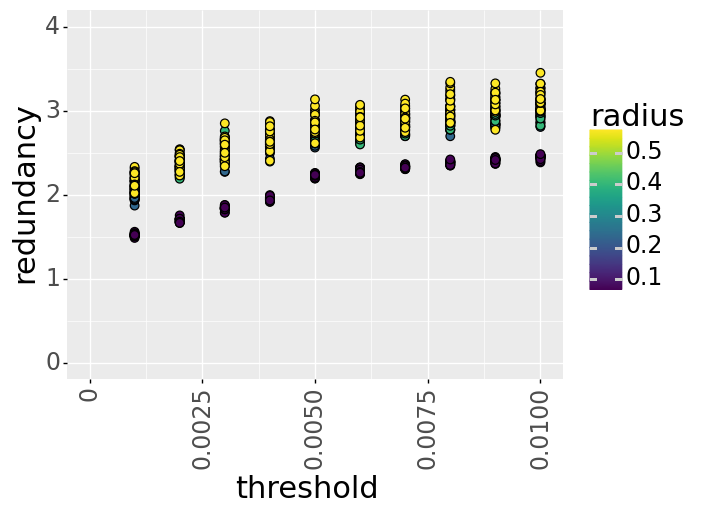

<ggplot: (167427531933)>

In [7]:
experiment_name = 'experiment1-pcGenerationThreshold'
folder_experiment = folder_log + experiment_name + '/'
folder_results = folder_experiment + 'configs/'
file_configs = folder_configs + experiment_name + '.csv'
metrics = pd.read_csv(folder_experiment + 'resulting_pc_layer_metrics.csv')

p = ggplot(metrics, aes('threshold','num_pcs',fill='radius'))
p += geom_point(size=3)
p += labs(x='threshold', y='Place cells created', title='')
p += theme(axis_text_x=element_text(rotation=90, hjust=0.5))

    
display(p)

p += coord_cartesian(ylim=[0,1550], xlim=[0, 0.1])
display(p)

p += coord_cartesian(ylim=[0,1000], xlim=[0, 0.01])
display(p)

p += coord_cartesian(ylim=[0,50], xlim=[0, 0.1])
display(p)

p += coord_cartesian(ylim=[0,250], xlim=[0, 0.1])
display(p)


p = ggplot(metrics, aes('threshold','redundancy',fill='radius'))
p += geom_point(size=3)
p += labs(x='threshold', y='redundancy', title='')
p += theme(axis_text_x=element_text(rotation=90, hjust=0.5))

    
display(p)

p += coord_cartesian(ylim=[0,7.5], xlim=[0,0.1])
display(p)

p += coord_cartesian(ylim=[0,4], xlim=[0, 0.01])
display(p)



In [44]:
# plot a table with average results:
file_configs = folder_configs + 'experiment1-pcGenerationThreshold.csv'
folder_experiment = folder_log + 'experiment1-pcGenerationThreshold/'
folder_figures = folder_experiment + 'figures/'
make_folder(folder_figures)


metrics = pd.read_csv(folder_experiment + 'resulting_pc_layer_metrics.csv')
averages = metrics.groupby(['radius','threshold'])[['num_pcs','redundancy']].mean().reset_index()

num_pcs = averages.pivot(index='radius', columns='threshold')['num_pcs']
redundancy = averages.pivot(index='radius', columns='threshold')['redundancy']

import dataframe_image as dfi
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(averages.pivot(index='radius', columns='threshold')['num_pcs'])
    display(averages.pivot(index='radius', columns='threshold')['redundancy'])

    dfi.export(num_pcs,folder_figures + "num_pcs.png", max_cols=-1)
    dfi.export(redundancy,folder_figures + "redundancy.png", max_cols=-1)

    

threshold   0.001   0.002   0.003  0.004   0.005   0.006   0.007   0.008  \
radius                                                                     
0.08       515.25  574.50  623.60  661.4  755.35  774.05  789.30  806.50   
0.24        82.80   95.70  100.25  107.3  110.05  113.05  115.35  117.50   
0.40        34.85   39.35   41.45   43.5   44.75   45.70   47.15   47.55   
0.56        19.80   21.75   23.30   24.3   25.85   26.45   26.20   27.70   

threshold  0.009   0.010   0.020    0.030    0.040    0.050    0.060    0.070  \
radius                                                                          
0.08       816.0  828.55  931.85  1013.25  1088.10  1157.80  1223.70  1283.85   
0.24       118.9  121.70  137.05   150.20   161.35   171.15   200.55   206.65   
0.40        49.3   49.55   58.50    65.40    69.15    73.15    76.50    79.45   
0.56        27.8   28.45   33.00    35.70    38.45    41.20    44.35    45.45   

threshold    0.080    0.090    0.100    0.200    0.300    0.400    0.500  \
radius                                                                     
0.08       1337.60  1396.10  1450.35  1992.85  2765.30  3517.40  4396.85   
0.24        215.70   228.15   234.00   308.15   388.85   496.50   752.70   
0.40         84.05    86.30    95.05   126.65   159.35   218.85   273.90   
0.56         47.80    49.05    51.00    71.75    94.95   118.60   146.05   

threshold    0.600   0.700     0.800     0.900  
radius                                          
0.08       5725.00  7698.4  10980.20  17861.25  
0.24        927.45  1249.3   1863.90   3847.40  
0.40        352.25   476.3    830.35   1524.55  
0.56        208.10   273.4    403.75    881.35

threshold     0.001     0.002     0.003     0.004     0.005     0.006  \
radius                                                                  
0.08       1.518248  1.693811  1.837430  1.948477  2.225471  2.280203   
0.24       1.984064  2.297611  2.412728  2.591486  2.653799  2.725418   
0.40       2.107818  2.382059  2.531220  2.665550  2.737787  2.814842   
0.56       2.193463  2.394352  2.598788  2.677259  2.862765  2.907974   

threshold     0.007     0.008     0.009     0.010     0.020     0.030  \
radius                                                                  
0.08       2.328699  2.378132  2.410205  2.445572  2.752500  2.999446   
0.24       2.790084  2.840722  2.869823  2.941812  3.333982  3.662671   
0.40       2.896906  2.944665  3.026128  3.083694  3.628613  4.085162   
0.56       2.933991  3.095518  3.105223  3.174684  3.685719  4.046586   

threshold     0.040     0.050     0.060     0.070     0.080     0.090  \
radius                                                                  
0.08       3.226424  3.432384  3.629061  3.808838  3.968755  4.143684   
0.24       3.949082  4.196615  4.900589  5.063111  5.293203  5.606955   
0.40       4.324156  4.588583  4.796832  5.010953  5.292170  5.466012   
0.56       4.367464  4.687801  5.046933  5.157886  5.423632  5.628008   

threshold     0.100     0.200      0.300      0.400      0.500      0.600  \
radius                                                                      
0.08       4.304991  5.919154   8.215443  10.467095  13.092425  17.044746   
0.24       5.745935  7.645958   9.709933  12.436161  18.825328  23.337828   
0.40       6.006306  8.091960  10.269847  14.107298  17.781927  22.991224   
0.56       5.822188  8.287706  11.081698  13.977882  17.277111  24.770578   

threshold      0.700      0.800       0.900  
radius                                       
0.08       22.931922  32.706114   53.132293  
0.24       31.506303  47.117975   97.370777  
0.40       31.285269  54.642798  100.892358  
0.56       32.833393  48.967012  107.484079

0          0
1          1
2          2
3          3
4          4
        ... 
1075    1075
1076    1076
1077    1077
1078    1078
1079    1079
Name: Unnamed: 0, Length: 1080, dtype: int64

# Experiment 2 - optimal threshold

## Load experiment data

In [3]:
# EXPERIMENT FOLDERS
folder_experiment = folder_log + 'experiment2-optimalThreshold/'
folder_figures = folder_experiment + 'figures/'
make_folder(folder_figures)

# LOAD DATABASE AND CONFIGS
sample_rate = 5
db = sqlite3.connect(folder_experiment + 'experiment_results.sqlite')
configs = load_config_file(folder_experiment)
configs['threshold'] = configs.pc_generation_threshold
configs['scale'] =  configs.pc_generation_radii
# configs['threshold']  = pd.Categorical(configs.threshold, np.sort(configs.pc_generation_threshold.unique()))
display(configs)


# GET DATA
merge_fields = ['threshold', 'scale','maze']
episode = lastEpisode(configs, sample_rate)

summaries, last_episode_metrics = getEpisodeDataAndRuntimeSummaries(db, configs, merge_fields, episode)
learning_times = getLearningTimes(db, configs, merge_fields)


display(Markdown("## Runtime summaries"), summaries)
display(Markdown('## Last episode metrics'),last_episode_metrics)
display(Markdown('## Learning times'), learning_times)




experiment group  \
config                                              
c0      experiments/setups/experiment_1.xml    g1   
c1      experiments/setups/experiment_1.xml    g1   
c2      experiments/setups/experiment_1.xml    g1   
c3      experiments/setups/experiment_1.xml    g1   
c4      experiments/setups/experiment_1.xml    g1   
...                                     ...   ...   
c220    experiments/setups/experiment_1.xml    g1   
c221    experiments/setups/experiment_1.xml    g1   
c222    experiments/setups/experiment_1.xml    g1   
c223    experiments/setups/experiment_1.xml    g1   
c224    experiments/setups/experiment_1.xml    g1   

                                               mazeFile  numEpisodes  \
config                                                                 
c0      experiments/mazes/generative_experiments/M0.xml        66000   
c1      experiments/mazes/generative_experiments/M0.xml        66000   
c2      experiments/mazes/generative_experiments/M0.xml        66000   
c3      experiments/mazes/generative_experiments/M0.xml        66000   
c4      experiments/mazes/generative_experiments/M0.xml        66000   
...                                                 ...          ...   
c220    experiments/mazes/generative_experiments/M4.xml        66000   
c221    experiments/mazes/generative_experiments/M4.xml        66000   
c222    experiments/mazes/generative_experiments/M4.xml        66000   
c223    experiments/mazes/generative_experiments/M4.xml        66000   
c224    experiments/mazes/generative_experiments/M4.xml        66000   

        numStartingPositions                         pc_files  \
config                                                          
c0                        22  experiments/pc_layers/empty.csv   
c1                        22  experiments/pc_layers/empty.csv   
c2                        22  experiments/pc_layers/empty.csv   
c3                        22  experiments/pc_layers/empty.csv   
c4                        22  experiments/pc_layers/empty.csv   
...                      ...                              ...   
c220                      22  experiments/pc_layers/empty.csv   
c221                      22  experiments/pc_layers/empty.csv   
c222                      22  experiments/pc_layers/empty.csv   
c223                      22  experiments/pc_layers/empty.csv   
c224                      22  experiments/pc_layers/empty.csv   

        independent_pcs pc_modulation_method  pc_generation_radii  \
config                                                              
c0                False                 none                 0.08   
c1                False                 none                 0.08   
c2                False                 none                 0.08   
c3                False                 none                 0.08   
c4                False                 none                 0.08   
...                 ...                  ...                  ...   
c220              False                 none                 0.56   
c221              False                 none                 0.56   
c222              False                 none                 0.56   
c223              False                 none                 0.56   
c224              False                 none                 0.56   

       pc_generation_method  pc_generation_threshold  \
config                                                 
c0                    layer                    0.001   
c1                    layer                    0.002   
c2                    layer                    0.003   
c3                    layer                    0.004   
c4                    layer                    0.005   
...                     ...                      ...   
c220                  layer                    0.500   
c221                  layer                    0.600   
c222                  layer                    0.700   
c223                  layer                   

## Runtime summaries

config  episode     median  c_id  threshold  scale maze
0            0        0  16.328930     0      0.001   0.08   M0
1            0        5  11.345619     0      0.001   0.08   M0
2            0       10   9.134910     0      0.001   0.08   M0
3            0       15   8.826843     0      0.001   0.08   M0
4            0       20   8.675243     0      0.001   0.08   M0
...        ...      ...        ...   ...        ...    ...  ...
134995     224     2975   0.470414   224      0.900   0.56   M4
134996     224     2980   0.497041   224      0.900   0.56   M4
134997     224     2985   0.483235   224      0.900   0.56   M4
134998     224     2990   0.469428   224      0.900   0.56   M4
134999     224     2995   0.465483   224      0.900   0.56   M4

[135000 rows x 7 columns]

## Last episode metrics

config  episode  rat   steps  error_rate  c_id  threshold  scale maze
0          0     2995    0   740.0    0.029207     0      0.001   0.08   M0
1          0     2995    1   727.0    0.011127     0      0.001   0.08   M0
2          0     2995    2   736.0    0.023644     0      0.001   0.08   M0
3          0     2995    3   736.0    0.023644     0      0.001   0.08   M0
4          0     2995    4   732.0    0.018081     0      0.001   0.08   M0
...      ...      ...  ...     ...         ...   ...        ...    ...  ...
4495     224     2995   15  1647.0    0.624260   224      0.900   0.56   M4
4496     224     2995   16  1481.0    0.460552   224      0.900   0.56   M4
4497     224     2995   17  1511.0    0.490138   224      0.900   0.56   M4
4498     224     2995   18  1475.0    0.454635   224      0.900   0.56   M4
4499     224     2995   19  1491.0    0.470414   224      0.900   0.56   M4

[4500 rows x 9 columns]

## Learning times

config  rat  learning_time  c_id  threshold  scale maze
0          0    0            128     0      0.001   0.08   M0
1          0    1            157     0      0.001   0.08   M0
2          0    2            133     0      0.001   0.08   M0
3          0    3            136     0      0.001   0.08   M0
4          0    4            144     0      0.001   0.08   M0
...      ...  ...            ...   ...        ...    ...  ...
4495     224   15           1475   224      0.900   0.56   M4
4496     224   16           1397   224      0.900   0.56   M4
4497     224   17           1528   224      0.900   0.56   M4
4498     224   18           1301   224      0.900   0.56   M4
4499     224   19           1361   224      0.900   0.56   M4

[4500 rows x 7 columns]

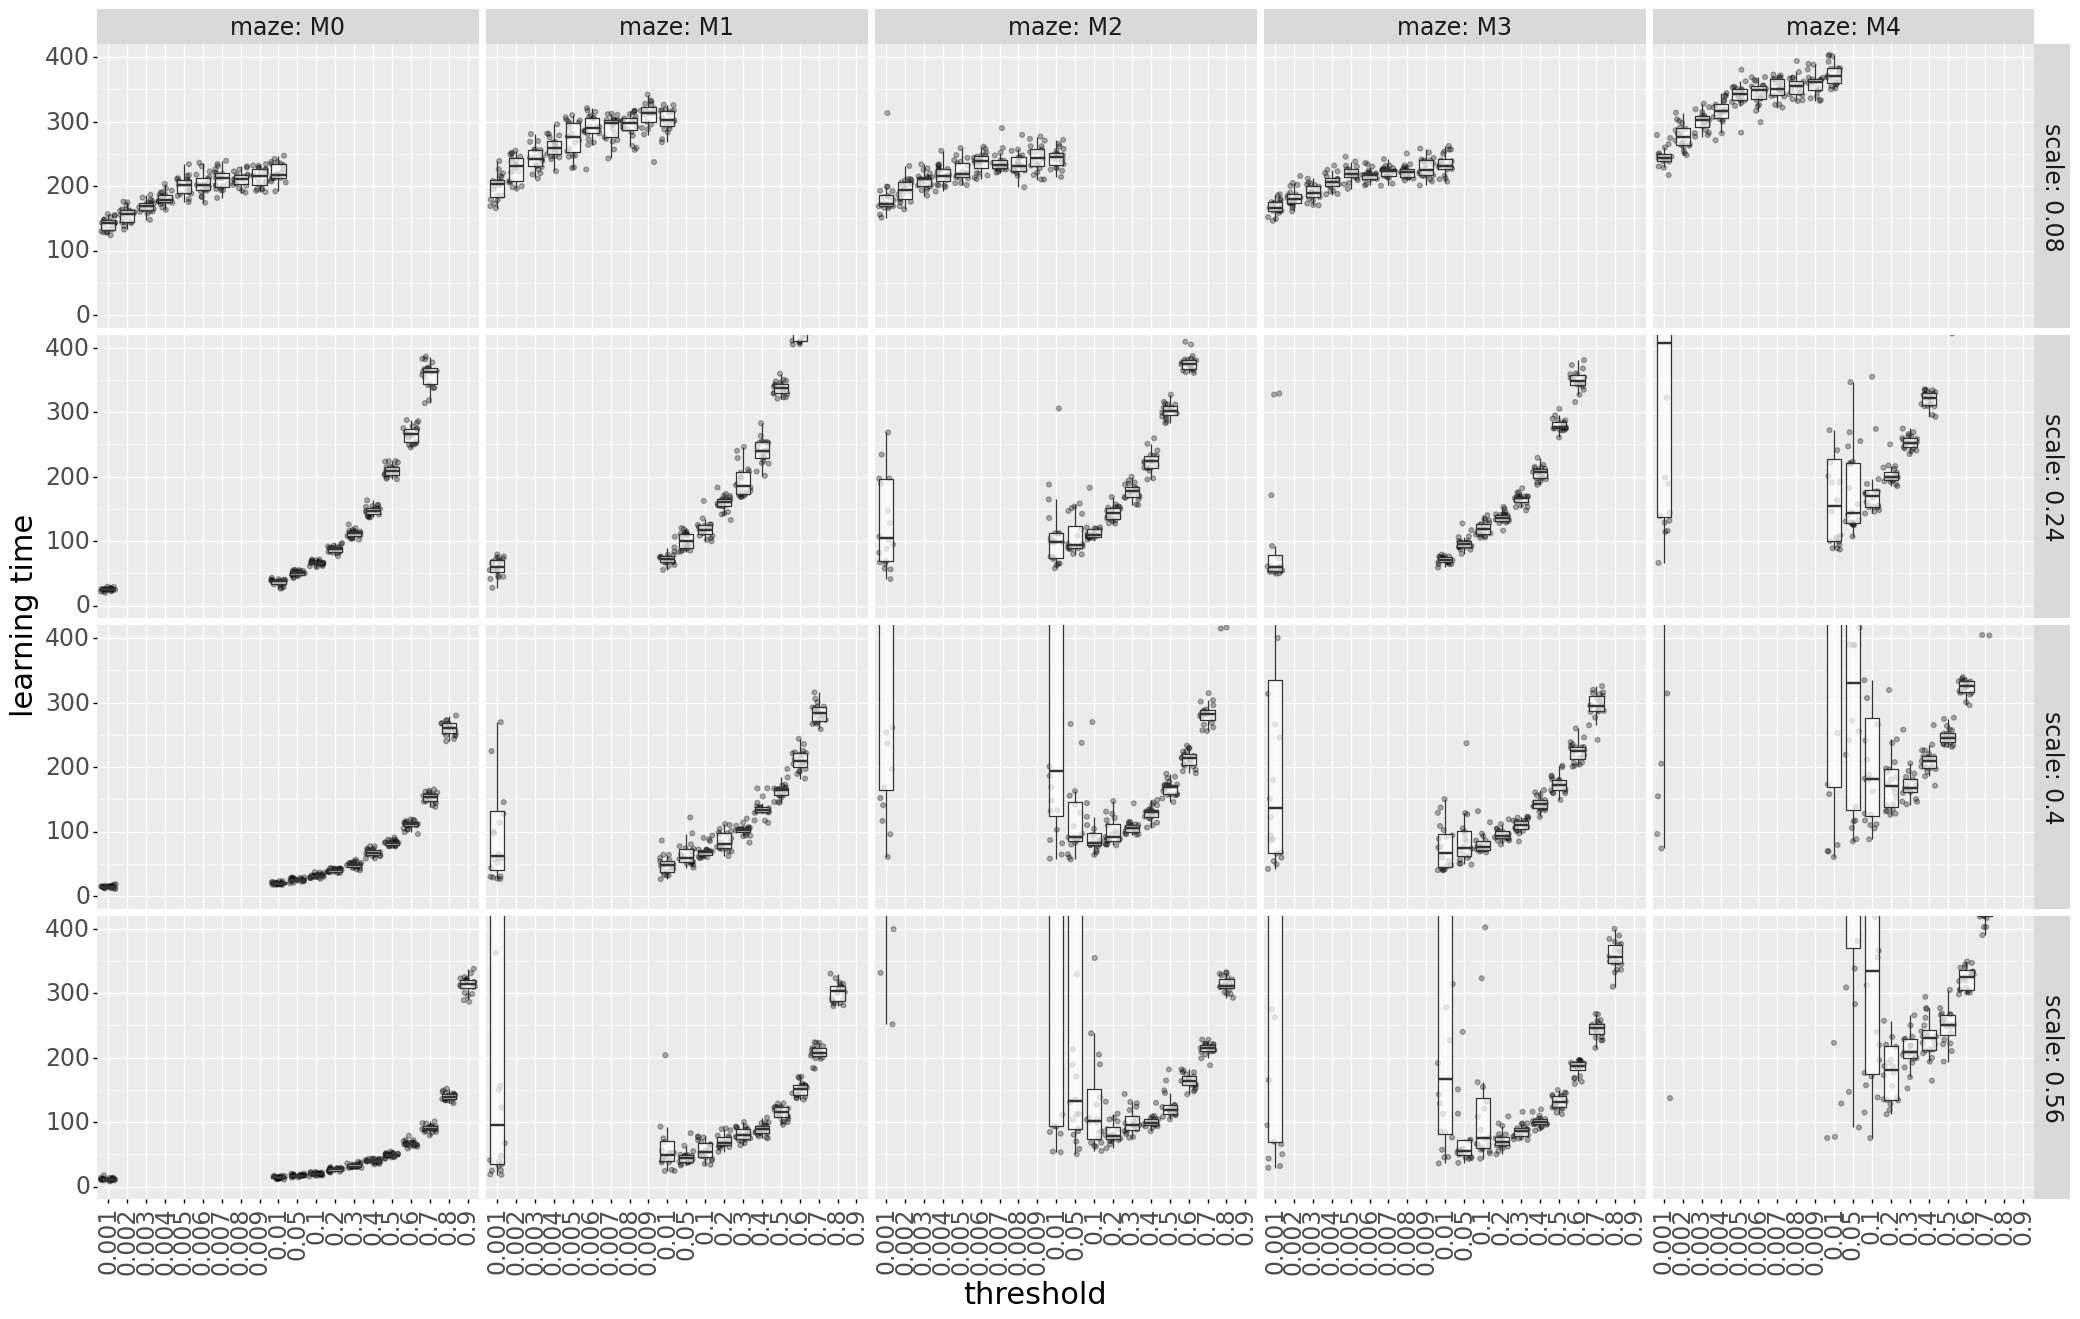

<ggplot: (99110737794)>

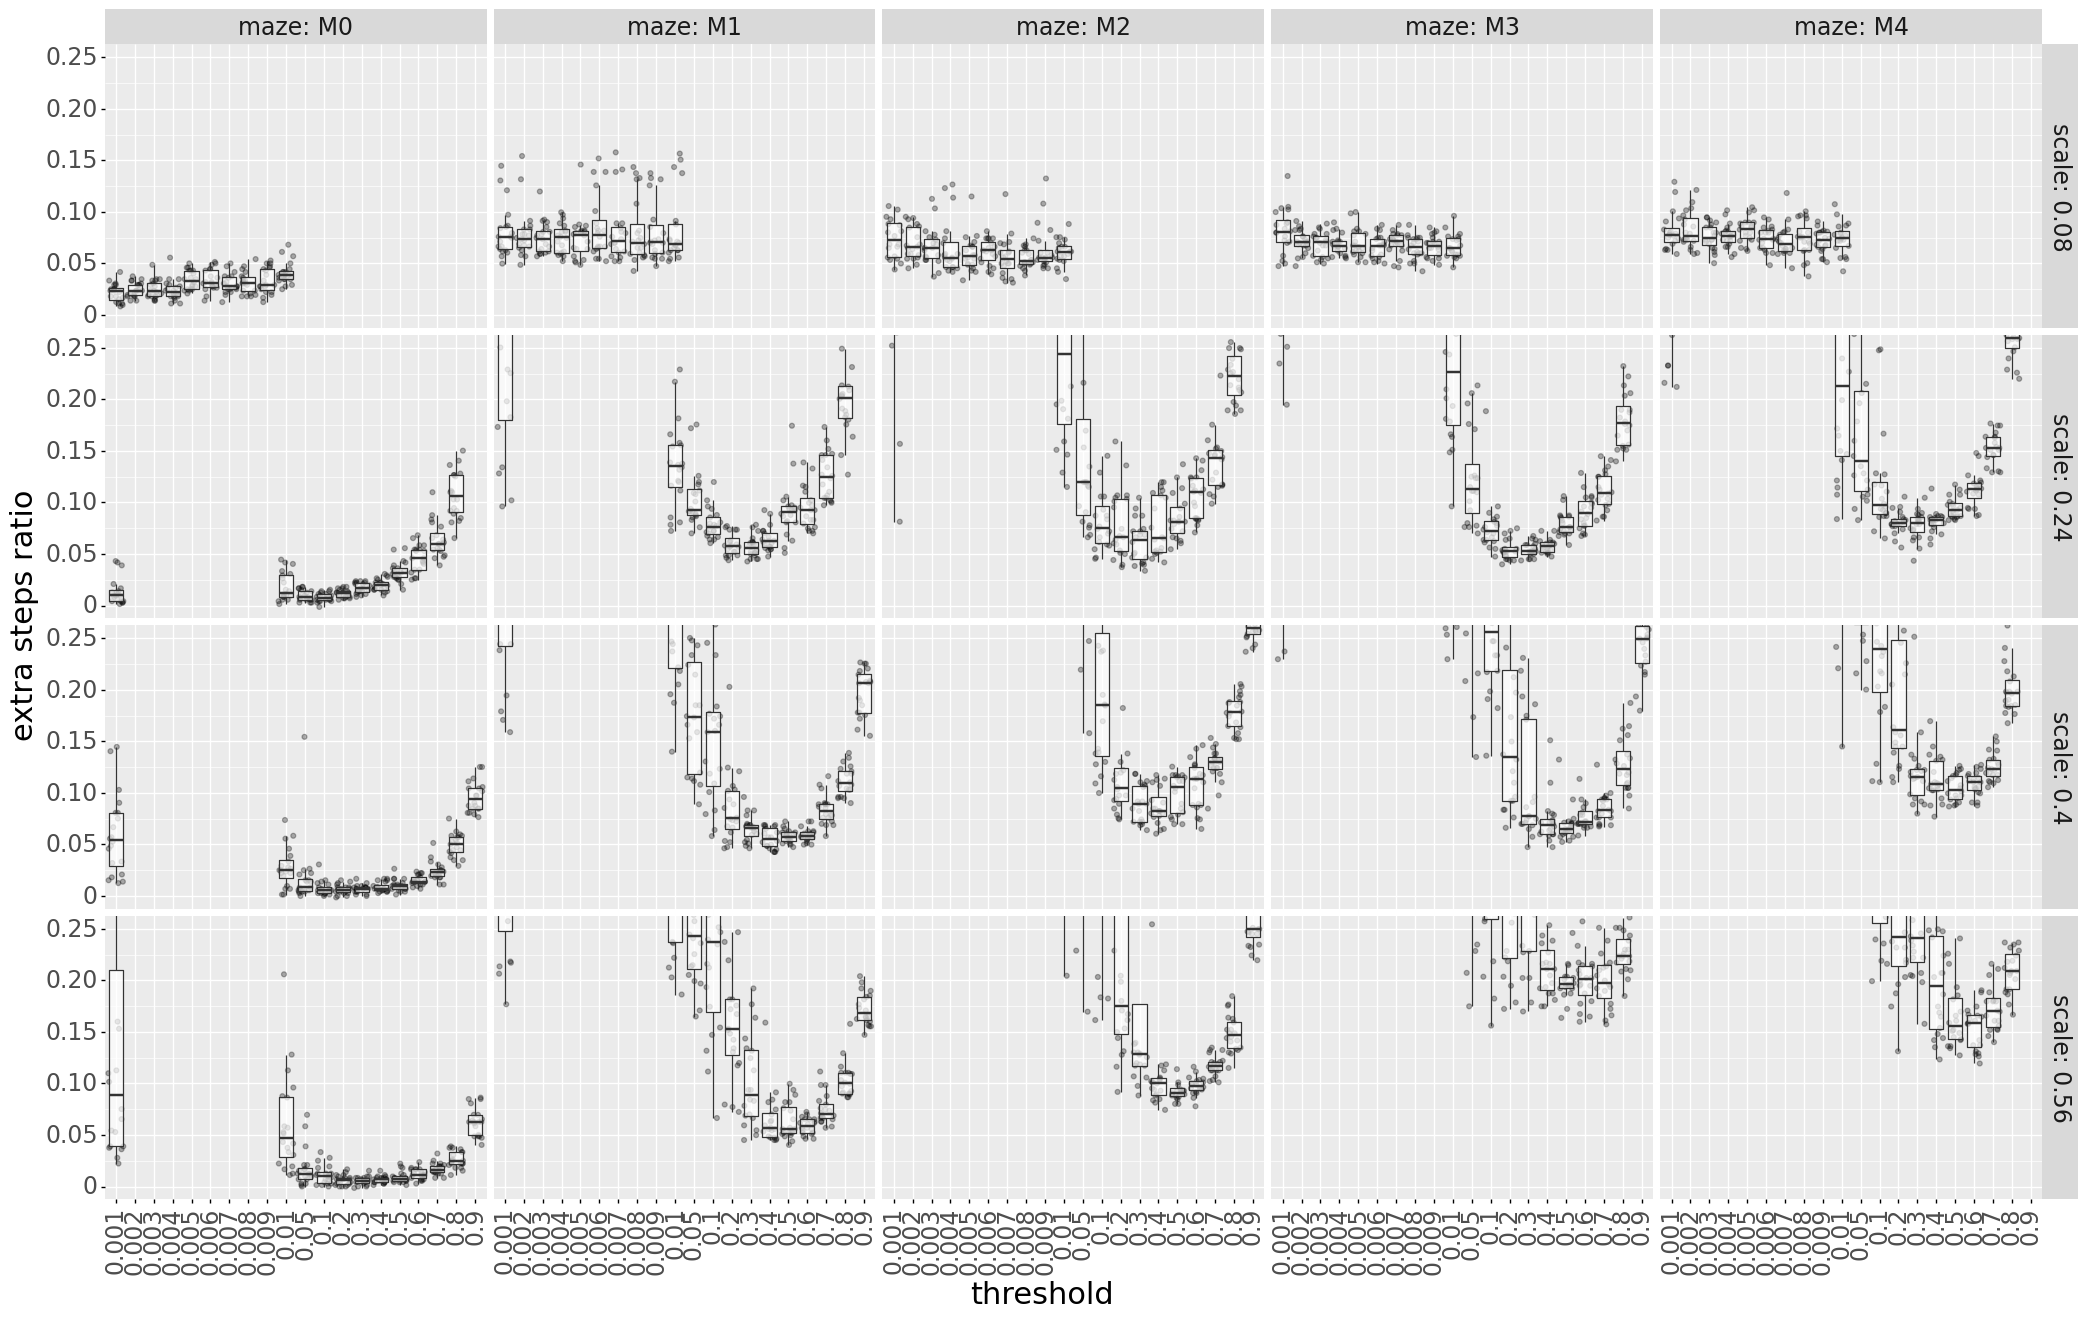

<ggplot: (99118002679)>

In [4]:
def do_plot(data, metric, y_title):
    p = ggplot(data, aes('threshold_c', metric ))
    p += facet_grid(f'scale ~ maze', scales='free', labeller='label_both')
    p += geom_jitter(alpha=0.3, position=position_jitter(), mapping=aes(group='threshold'))
    p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p += labs(x='threshold', y=y_title, title='')
    p += theme_gray() 
    p += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        legend_position = "none",
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
        aspect_ratio=None,
        figure_size=(25, 15)
    )
    return p

# summaries, last_episode_metrics = getEpisodeDataAndRuntimeSummaries(db, configs, merge_fields, episode)
# learning_times = getLearningTimes(db, configs, merge_fields
learning_times['threshold_c'] = learning_times.threshold.astype("category")
p = do_plot(learning_times,'learning_time', 'learning time')

p2 = p + coord_cartesian(ylim=[0,400])
ggsave(p2, folder_figures + 'learning_times_400.png', dpi=300, verbose = False)
display(p2)


last_episode_metrics['threshold_c'] = last_episode_metrics.threshold.astype("category")
p = do_plot(last_episode_metrics,'error_rate', 'extra steps ratio')

p2 = p + coord_cartesian(ylim=[0,0.25])
ggsave(p2, folder_figures + 'extra_steps_25.png', dpi=300, verbose = False)
display(p2)

# Experiment 3 - multiscale

In [52]:
# LOAD CONFIGS FROM EXPERIMENT 2
folder_experiment = folder_log + 'experiment2-optimalThreshold/'
desired_configs = {0.08:0.004, 0.24:0.3, 0.40:0.4, 0.56:0.6}

# CONFIGS TO LOAD:
configs = load_config_file(folder_experiment)
configs['threshold'] = configs.pc_generation_threshold
configs['mix_name'] =  configs.pc_generation_radii
results = configs.apply(lambda row : (row['mix_name'] in desired_configs.keys()) and (desired_configs[row['mix_name']]==row['threshold']) , axis=1) # 
configs = configs.loc[results]
configs.mix_name = configs.mix_name.apply(lambda x : f'{x}')

# GET DATA
sample_rate = 5
merge_fields = ['maze','mix_name','threshold']
episode = lastEpisode(configs, sample_rate)
db = sqlite3.connect(folder_experiment + 'experiment_results.sqlite')

summaries_e2, last_episode_metrics_e2 = getEpisodeDataAndRuntimeSummaries(db, configs, merge_fields, episode)
learning_times_e2 = getLearningTimes(db, configs, merge_fields)
def add_ratios(data):
    copies = [ data.copy() for i in range(1,6) ]
    for i,c in zip(range(1,6), copies):
        c['ratio'] = 0.2*i
    return pd.concat(copies)
summaries_e2 = add_ratios(summaries_e2)
last_episode_metrics_e2 = add_ratios(last_episode_metrics_e2)
learning_times_e2 = add_ratios(learning_times_e2)
configs2 = add_ratios(configs)


# display(configs2)

# LOAD CONFIGS FROM EXPERIMENT 3
folder_experiment = folder_log + 'experiment3-multiscale/'
folder_figures = folder_experiment + 'figures/'
make_folder(folder_figures)

# CONFIGS TO LOAD:
configs = load_config_file(folder_experiment)
configs['threshold'] = configs.pc_generation_threshold
configs['ratio'] = configs.pc_modulation_ratio

# GET DATA
sample_rate = 5
merge_fields = ['ratio', 'maze','mix_name','threshold']
episode = lastEpisode(configs, sample_rate)
db = sqlite3.connect(folder_experiment + 'experiment_results.sqlite')

summaries_e3, last_episode_metrics_e3 = getEpisodeDataAndRuntimeSummaries(db, configs, merge_fields, episode)
learning_times_e3 = getLearningTimes(db, configs, merge_fields)


summaries = pd.concat([summaries_e3, summaries_e2])
last_episode_metrics = pd.concat([last_episode_metrics_e3,last_episode_metrics_e2])
learning_times = pd.concat([learning_times_e3,learning_times_e2])

learning_times.ratio = learning_times.ratio.apply(lambda x : f'{x:.1f}')
last_episode_metrics.ratio = last_episode_metrics.ratio.apply(lambda x : f'{x:.1f}')

display(Markdown("## Runtime summaries"), summaries)
display(Markdown('## Last episode metrics'),last_episode_metrics)
display(Markdown('## Learning times'), learning_times)

## Runtime summaries

config  episode     median  c_id  ratio maze mix_name  \
0           0        0  16.156467     0    0.2   M0     max0   
1           0        5   8.757998     0    0.2   M0     max0   
2           0       10   7.775383     0    0.2   M0     max0   
3           0       15   5.700974     0    0.2   M0     max0   
4           0       20   3.568846     0    0.2   M0     max0   
...       ...      ...        ...   ...    ...  ...      ...   
11995     221     2975   0.146943   221    1.0   M4     0.56   
11996     221     2980   0.141519   221    1.0   M4     0.56   
11997     221     2985   0.143491   221    1.0   M4     0.56   
11998     221     2990   0.142505   221    1.0   M4     0.56   
11999     221     2995   0.158284   221    1.0   M4     0.56   

                     threshold  
0      0.001,0.001,0.001,0.001  
1      0.001,0.001,0.001,0.001  
2      0.001,0.001,0.001,0.001  
3      0.001,0.001,0.001,0.001  
4      0.001,0.001,0.001,0.001  
...                        ...  
11995                      0.6  
11996                      0.6  
11997                      0.6  
11998                      0.6  
11999                      0.6  

[165000 rows x 8 columns]

## Last episode metrics

config  episode  rat   steps  error_rate  c_id  ratio maze mix_name  \
0         0     2995    0   725.0    0.008345     0    0.2   M0     max0   
1         0     2995    1   747.0    0.038943     0    0.2   M0     max0   
2         0     2995    2   727.0    0.011127     0    0.2   M0     max0   
3         0     2995    3   728.0    0.012517     0    0.2   M0     max0   
4         0     2995    4   720.0    0.001391     0    0.2   M0     max0   
..      ...      ...  ...     ...         ...   ...    ...  ...      ...   
395     221     2995   15  1135.0    0.119329   221    1.0   M4     0.56   
396     221     2995   16  1174.0    0.157791   221    1.0   M4     0.56   
397     221     2995   17  1177.0    0.160750   221    1.0   M4     0.56   
398     221     2995   18  1175.0    0.158777   221    1.0   M4     0.56   
399     221     2995   19  1142.0    0.126233   221    1.0   M4     0.56   

                   threshold  
0    0.001,0.001,0.001,0.001  
1    0.001,0.001,0.001,0.001  
2    0.001,0.001,0.001,0.001  
3    0.001,0.001,0.001,0.001  
4    0.001,0.001,0.001,0.001  
..                       ...  
395                      0.6  
396                      0.6  
397                      0.6  
398                      0.6  
399                      0.6  

[5500 rows x 10 columns]

## Learning times

config  rat  learning_time  c_id  ratio maze mix_name  \
0         0    0             36     0    0.2   M0     max0   
1         0    1             34     0    0.2   M0     max0   
2         0    2             36     0    0.2   M0     max0   
3         0    3             35     0    0.2   M0     max0   
4         0    4             34     0    0.2   M0     max0   
..      ...  ...            ...   ...    ...  ...      ...   
395     221   15            333   221    1.0   M4     0.56   
396     221   16            298   221    1.0   M4     0.56   
397     221   17            301   221    1.0   M4     0.56   
398     221   18            349   221    1.0   M4     0.56   
399     221   19            340   221    1.0   M4     0.56   

                   threshold  
0    0.001,0.001,0.001,0.001  
1    0.001,0.001,0.001,0.001  
2    0.001,0.001,0.001,0.001  
3    0.001,0.001,0.001,0.001  
4    0.001,0.001,0.001,0.001  
..                       ...  
395                      0.6  
396                      0.6  
397                      0.6  
398                      0.6  
399                      0.6  

[5500 rows x 8 columns]

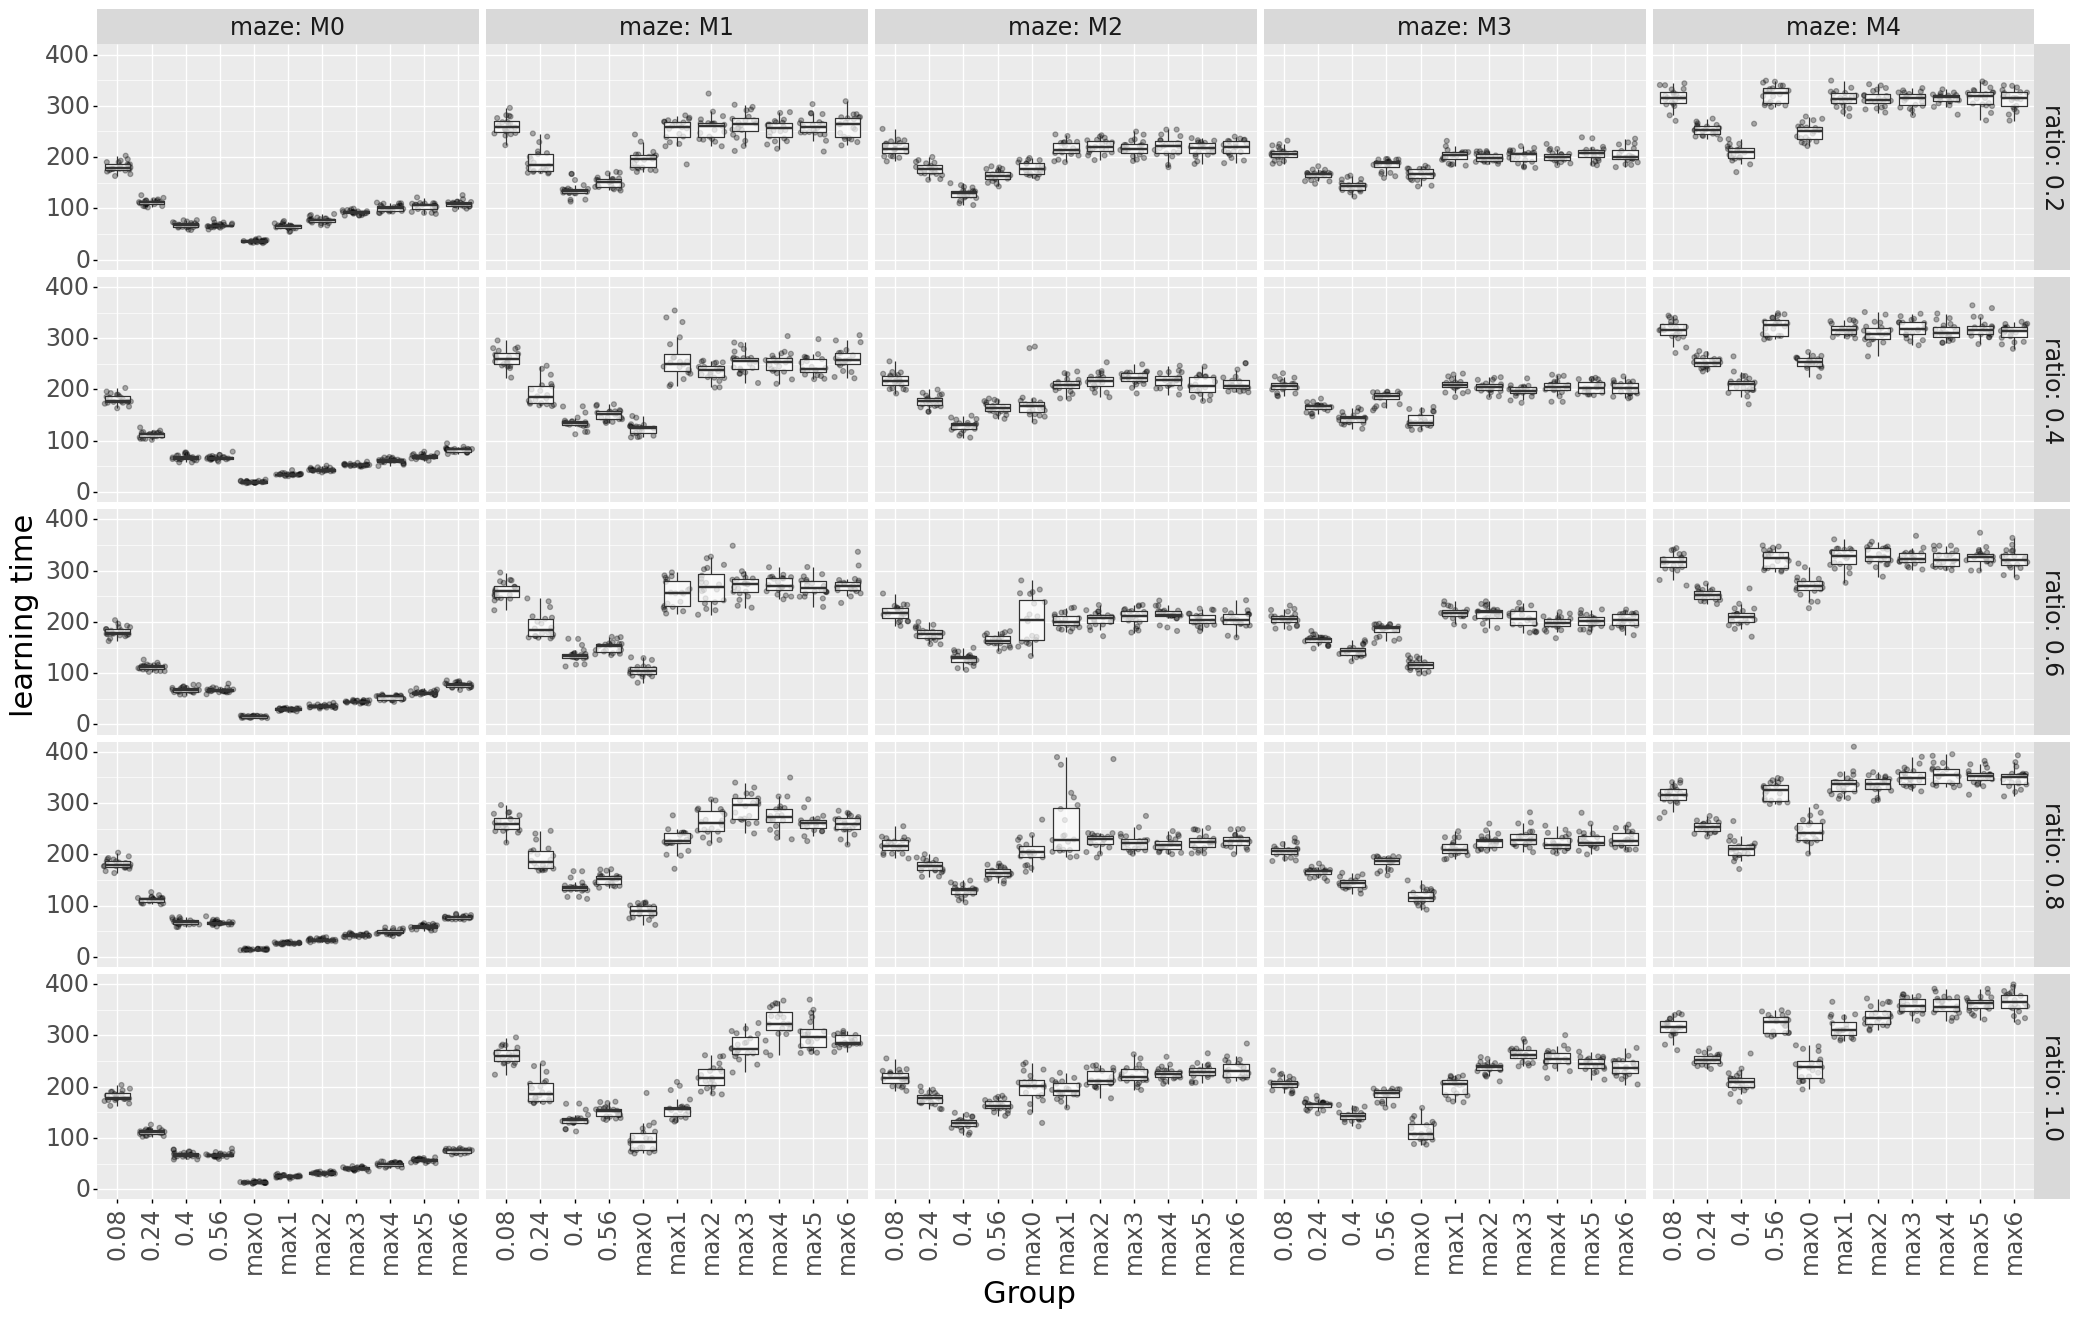

<ggplot: (99117530950)>

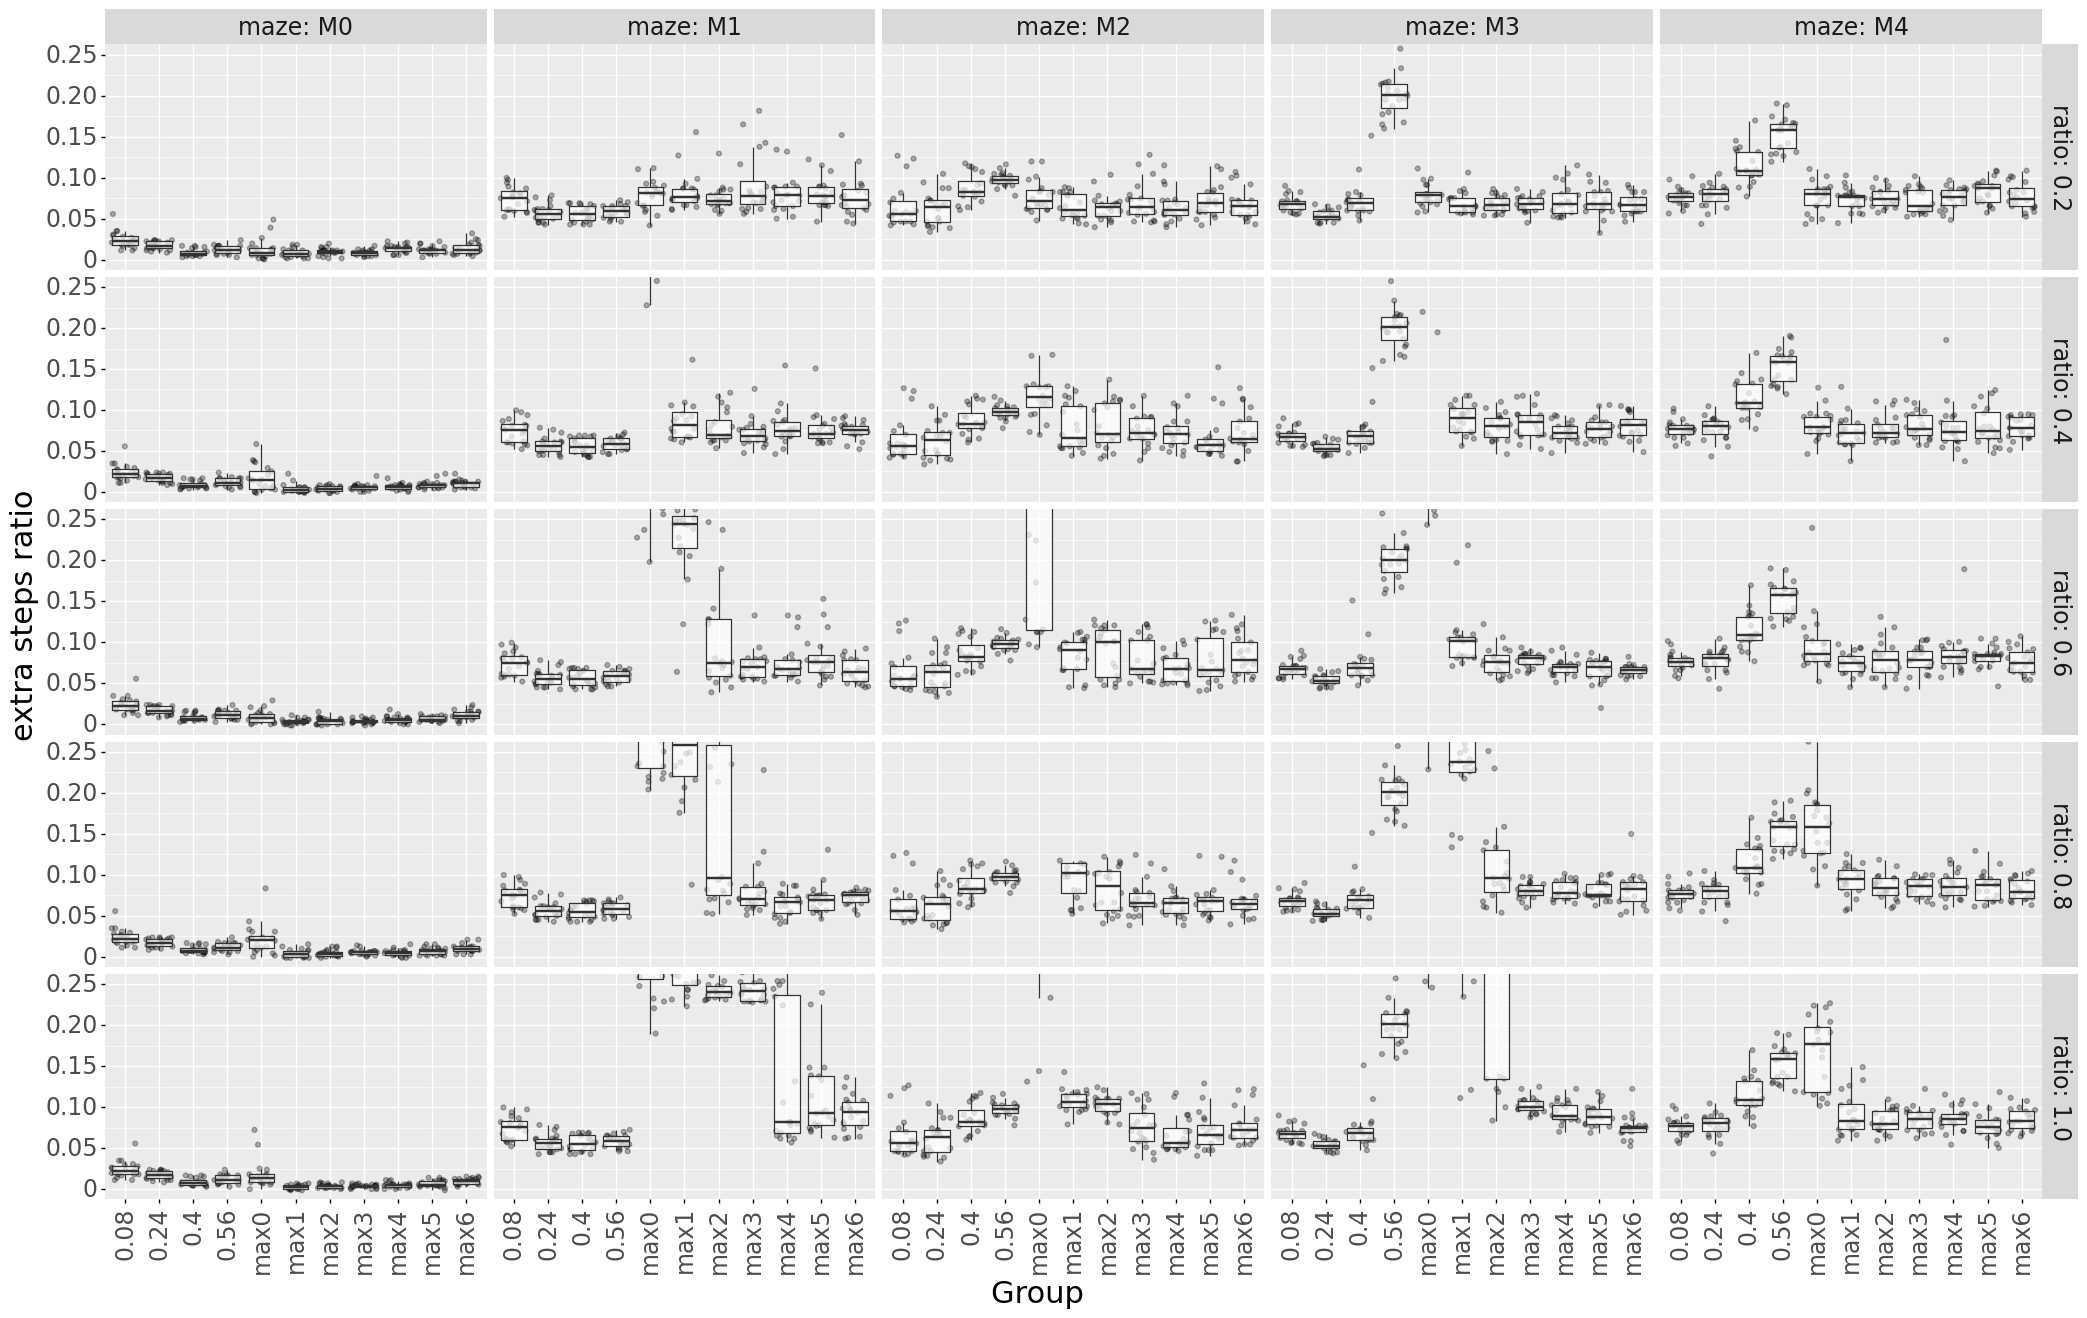

<ggplot: (99115572685)>

In [58]:

def do_plot(data, metric, y_title):
    p = ggplot(data, aes('mix_name', metric ))
    p += facet_grid(f'ratio ~ maze', scales='free', labeller='label_both')
    p += geom_jitter(alpha=0.3, position=position_jitter(), mapping=aes(group='mix_name'))
    p += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0)
    p += labs(x='Group ', y=y_title, title='')
    p += theme_gray() 
    p += theme(
        axis_text_x=element_text(rotation=90, hjust=0.5), 
        legend_position = "none",
        plot_title = element_text(size = 28), #32
        axis_title = element_text(size = 22), #26
        legend_title = element_text(size = 22), #26
        legend_text = element_text(size = 17), #22
        axis_text = element_text(size=17), #16
        strip_text_x = element_text(size=17), #16
        strip_text_y = element_text(size=17), #16
        aspect_ratio=None,
        figure_size=(25, 15)
    )
    return p

# summaries, last_episode_metrics = getEpisodeDataAndRuntimeSummaries(db, configs, merge_fields, episode)
# learning_times = getLearningTimes(db, configs, merge_fields
# learning_times['threshold_c'] = learning_times.threshold.astype("category")
# display(learning_times)

p = do_plot(learning_times,'learning_time', 'learning time')
# ggsave(p, folder_figures + 'learning_times.png', dpi=300, verbose = False)
# display(p)
p2 = p + coord_cartesian(ylim=[0,400])
ggsave(p2, folder_figures + 'learning_times_400.png', dpi=300, verbose = False)
display(p2)


# last_episode_metrics['threshold_c'] = last_episode_metrics.threshold.astype("category")

p = do_plot(last_episode_metrics,'error_rate', 'extra steps ratio')
# ggsave(p, folder_figures + 'extra_steps.png', dpi=300, verbose = False)
# display(p)
p2 = p + coord_cartesian(ylim=[0,0.25])
ggsave(p2, folder_figures + 'extra_steps_25.png', dpi=300, verbose = False)
display(p2)

# Experiment 4 -

# Experiment 5 -

# Experiment 6 -

# MAZE PLOTTER

File exists!


x       y         d
0      -1.1025 -1.5025  0.223215
1      -1.0975 -1.5025  0.218403
2      -1.0925 -1.5025  0.213600
3      -1.0875 -1.5025  0.208806
4      -1.0825 -1.5025  0.204022
...        ...     ...       ...
265036  1.0775  1.4975  0.217830
265037  1.0825  1.4975  0.222092
265038  1.0875  1.4975  0.226385
265039  1.0925  1.4975  0.230705
265040  1.0975  1.4975  0.235053

[265041 rows x 3 columns]

'sample_maze2'

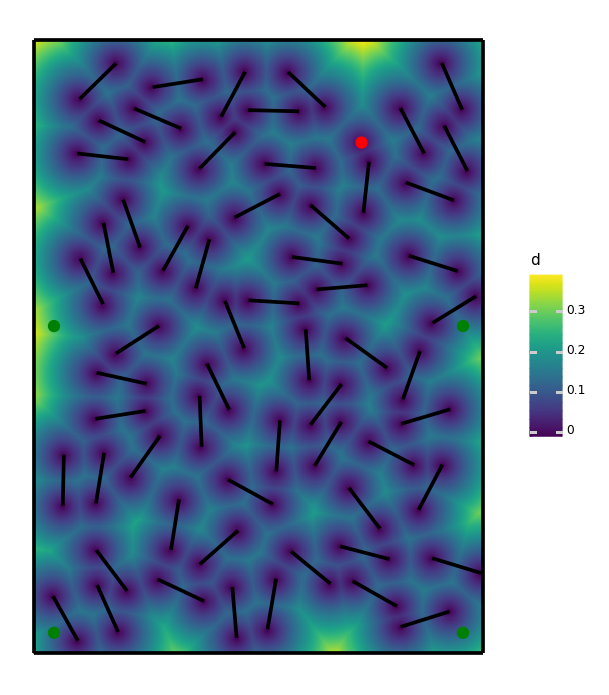

<ggplot: (115688917520)>

In [ ]:
folder_mazes = 'experiments/mazes/' 
folder_layers = 'experiments/pc_layers/'
folder_maze_figures = 'figures/'
make_folder(folder_maze_figures)
pc_files = [
    #'uniform/u20_10',
    #'uniform/u40_10',
    #'uniform/u20_15',
    #'uniform/u40_15',
    #'multi_layer/ml_4_16_52',
    #'multi_layer/ml_4_16_52',
    # 'uniform/u40_05',
    # 'locally_uniform/lu0_40_16',
    # 'locally_uniform/lu0_40_16',
    # 'locally_uniform/lu1_40_16',
    # 'non_uniform/non_uniform_0',
    # 'non_uniform/non_uniform_1',
    # 'non_uniform/non_uniform_8',
    'NONE' #'../../experiments/pc_generation_experiments/logs/test/configs/c0/r0-pc_layer0'
]
maze_files = [
    #'obstacles/M100',
    #'obstacles/M200',
    #'obstacles/M300',
    #'obstacles/M400',
    #'obstacles/M500',
    #'obstacles/M600',
    # 'M1',
    # 'M0',
    # 'M1',
    # 'M1',
    # 'M0',
    # 'M1',
    # 'M8',
    'obstacles/M600',
]

save_names = [
    #'M100_u20_10',
    #'M200_u40_15',
    #'M300_u20_15',
    #'M400_u40_15',
    #'M500_ml',
    #'M600_ml',
    # 'M1_u',
    # 'M0_lu0',
    # 'M1_lu0',
    # 'M1_lu1',
    # 'M0_nu',
    # 'M1_nu',
    # 'M2_nu'
    'sample_maze2'
]


thetas = np.arange(100)/100*2*np.pi
unit_circle = pd.DataFrame({'x':np.cos(thetas),'y':np.sin(thetas)})
def draw_circle(x,y,r, **kwargs):
    circle = unit_circle*r + [x,y]
    return geom_path(aes(x='x',y='y'), data=circle, **kwargs)


for (p_file, m_file, s_name) in zip(pc_files, maze_files, save_names):

    p = ggplot()
    
    
    
    # If maze file is not none and it has distance file, plot distance heatmap first
    d_file = folder_mazes + m_file + '_subgoal_distances.bin'
    if m_file != 'NONE' and os.path.exists(d_file):
        print('File exists!')
        with open(d_file,'rb') as f:
            [min_x, num_x, min_y, num_y, precision] = np.fromfile(f, np.float32, 5) # format is: 
            distances = np.fromfile(f, np.float32, int(num_x*num_y))
            [ys, xs] = np.mgrid[0:num_y,0:num_x].reshape(2,-1)
            xs = xs*precision + min_x
            ys = ys*precision + min_y
            distance_df = pd.DataFrame({'x':xs,'y':ys,'d':distances})
            display(distance_df)
            p += geom_tile(aes(x='x',y='y',fill='d'), data=distance_df)
    else:
        print(f'distance does not exist! {d_file}')
            
    
    # IF PCS is not none plot pcs:
    if p_file != 'NONE':
        pcs = pd.read_csv(folder_layers + p_file + '.csv')
        for id, pc in pcs.iterrows():
            p += draw_circle(pc['x'], pc['y'], pc['r'], color='gray')
    
    if m_file != 'NONE':
        walls, feeders, start_positions = parse_maze(folder_mazes + m_file + '.xml')
        p += geom_segment(aes(x='x1', y='y1', xend='x2', yend='y2'), data=walls, color='k', size=1.5)
        p += geom_point(aes(x='x', y='y'), data=feeders, color='r', size=4)
        p += geom_point(aes(x='x', y='y'), data=start_positions, color='g', size=4)
        
    # ADD THEMES TO PLOT
    p += coord_fixed(ratio = 1)
    p += theme_void()

    display(s_name)
    display(p)
    
    if s_name != 'NONE':
        ggsave(p, folder_maze_figures + s_name + '.png', dpi=300, verbose = False)
    
